## Import Python Module

In [1]:
#gestion fichier modeles pythons
import os , sys            
workpath = sys.path[0]

sys.path.append(f'{workpath}\fidle-env\lib\site-packages')

#modules utilitaires
import random as r
import numpy as np
import time as t
import fidle
   
#traitement image
import matplotlib.pyplot as plt   
from skimage import io 

#module IA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.models import Model

#module de convertion d'image gris a RGB
import cv2



## les diffs choix de dataset.

In [5]:
datapath = f'{workpath}\datasheet\mmClasses-DataBase-IMG\mmClasses-DataBase-IMG\data_64'
run_dir="E:\INSA-cour\A4A\Projet_multi\work-dictory\\trained_model\model_64"
#fidle.utils.mkdir(".\trained_model")
fidle.utils.mkdir(run_dir)

In [59]:
datapath = f'{workpath}\datasheet\mmClasses-DataBase-IMG\mmClasses-DataBase-IMG\data_256'
run_dir="E:\INSA-cour\A4A\Projet_multi\work-dictory\\trained_model\model_256"
#fidle.utils.mkdir(".\trained_model")
fidle.utils.mkdir(run_dir)

In [ ]:
datapath = f'{workpath}\datasheet\mmClasses-DataBase-IMG\mmClasses-DataBase-IMG\data_64_fullmodif'
run_dir="E:\INSA-cour\A4A\Projet_multi\work-dictory\\trained_model\model_256_dataugmentation"
fidle.utils.mkdir(run_dir)

In [2]:
datapath = f'{workpath}\datasheet\mmClasses-DataBase-IMG\mmClasses-DataBase-IMG\data_128_equilibre'
descri_datapath = [datapath, 'img_128']
run_dir="E:\INSA-cour\A4A\Projet_multi\work-dictory\\trained_model\model_128_equilibre"
fidle.utils.mkdir(run_dir)

## Parameters for CNN and DNN

In [3]:
#pourcentage du dataset à load
scale = 0.3  #si on fait 256

#batch_size    = 64 # le batch size initial
batch_size    = 64
epochs        = 10
fit_verbosity = 1

index_to_class = ["CUBO","DEC","FCC","FCC-sphere","HCP-sphere","ICO","MnBeta_sphere","OH","RTD","BCC","DODECA"]

## Dataset loading

In [4]:
def read_dataset (filepath : str):
    """entrée : chemin vers le dossier contenant la BDD
    sortie : listes des images et leur classes respectives, mis à l'échelle (scale) et mélangées"""
    
    L = os.listdir(filepath)   #liste contenenant le nom (en .jpg) de toutes les images
    nb_files = len(L)
    nb_files2load = round(nb_files*scale)
    size = np.shape(io.imread(f'{filepath}/{L[0]}'))  #enlevant le as_gray =  True
    
    #initialisation listes sortie
    img = np.zeros ( (nb_files2load , size[0] , size[1]) , dtype = np.float16 )
    ID  = np.zeros ( nb_files2load , dtype = np.int8)
   
    for i in range (nb_files2load):
        
        random_index = r.randint(0 , nb_files - i - 1)
        img[i] = io.imread (f'{filepath}/{L[random_index]}', as_gray =  True)     #avec couleur: enlevant le as_gray =  True
        ID [i] = int (L[random_index][:3]) - 1
        L.pop(random_index)
        
    N = len(img)
    img_train = img[0:round(N*0.8)]
    img_test  = img[round(N*0.8):]
    ID_train = ID[0:round(N*0.8)]
    ID_test  = ID[round(N*0.8):]   
        
    return img_train,img_test,ID_train,ID_test


img_train , img_test , ID_train , ID_test = read_dataset(datapath) 

print(f'chaining dataset actual is {datapath}')
print(np.shape(img_train))
print(np.shape(img_test))
print(np.shape(ID_train))
print(np.shape(ID_test))

chaining dataset actual is E:\INSA-cour\A4A\Projet_multi\work-dictory\datasheet\mmClasses-DataBase-IMG\mmClasses-DataBase-IMG\data_128_equilibre
(4810, 128, 128)
(1203, 128, 128)
(4810,)
(1203,)


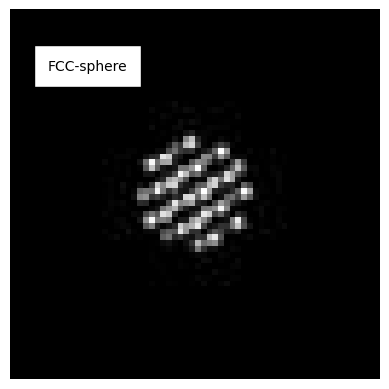

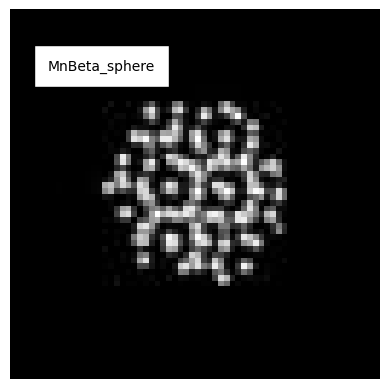

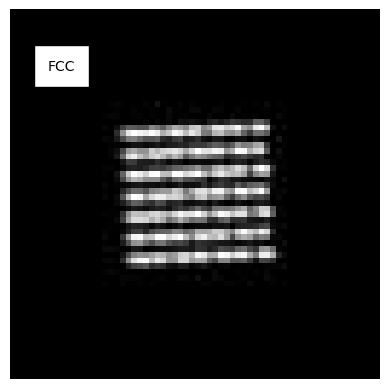

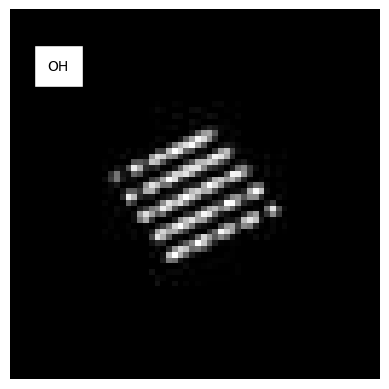

In [8]:
for i in range(4):
    fig, ax = plt.subplots()
    plt.imshow(img_train[i], cmap ="gray") #avec couleur: enlevant , cmap ="gray"
    plt.axis("off")
    ax.text(6,10,index_to_class[ID_train[i]], bbox={'facecolor': 'white', 'pad': 10})

## Model creation

In [5]:
def m_ince_11234(lx,ly): # _ince: en applicant les kernel 1*1
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(16, (1,1), padding = 'same',  activation='relu', input_shape=(lx,ly,1)))
    model.add( keras.layers.Conv2D(32, (3, 3), padding = 'same', activation='relu'))
    model.add( keras.layers.Conv2D(32, (3, 3), padding = 'same', activation='relu'))
    model.add( keras.layers.MaxPooling2D((3, 3)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(64, (3, 3), padding = 'same', activation='relu'))
    model.add( keras.layers.Conv2D(64, (3, 3), padding = 'same', activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(128, (3, 3),padding = 'same', activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))
    
    model.add( keras.layers.Conv2D(256, (3, 3),padding = 'same', activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( layers.Dense(700))
    model.add( layers.Dense(700))
    model.add( layers.Activation(activations.tanh)) 
    model.add( keras.layers.Dropout(0.3))

    model.add( keras.layers.Dense(11, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    code_model='2_700_11234'
    model_name = 'e'+str(epochs)+'bs'+str(batch_size)+'sc'+str(scale)+'code'+str(code_model)
    return model, model_name, code_model

(nb_img,lx,ly) = np.shape(img_train)
model, model_name,code_model = m_ince_11234(lx,ly)
 

In [6]:

model_name = 'e'+str(epochs)+'bs'+str(batch_size)+'sc'+str(scale)+'code'+str(code_model)

print(model_name)

e10bs64sc0.3code2_700_11234


## get output of some layers by index of layer, the 0 one is the layer with argument input_shape

In [7]:
# cette cellure contient des commands basique pour recuperer un lame
#print(model.layers) #print tous les layers  
layer8=model.layers[2]
convol_output=layer8.output
print(type(convol_output))

<class 'keras.engine.keras_tensor.KerasTensor'>


In [8]:
#layer_model: le layer avant flatten
layer_model= Model(inputs = model.input, outputs = convol_output)

#--ajouter des dim pour que la forme de matrix d'image adapte les fonctions de keras
#random_index = r.randint(0 , 4810)
random_index = 500
img_init = img_train[random_index]
img_tridim = img_train[random_index][:,:,np.newaxis]
print(f"shape img_tridim est {np.shape(img_tridim)}")
img_quadim = img_tridim[np.newaxis,:,:,:] #ici le dim de matric d'img est 4, mais rien ne change pas 
print(f"shape img_quadim est {np.shape(img_quadim)}")
"""
fig, ax = plt.subplots()
plt.imshow(img_tridim, cmap ="gray") #avec couleur: enlevant , cmap ="gray"
plt.axis("off")
"""
#convoluer l'image, le sortie est 64,64,32
img_convolued = layer_model.predict(img_quadim)
print(type(img_convolued))
print(f"shape image convolued est {np.shape(img_convolued)}")

shape img_tridim est (128, 128, 1)
shape img_quadim est (1, 128, 128, 1)
1/1 [==============================] - 0s 299ms/step
<class 'numpy.ndarray'>
shape image convolued est (1, 128, 128, 32)


## prelever un des resusltat de convolution parmis les convolution de nombre de profondeur de matrice

In [9]:
# on preleve matrice de indexieme channel, le dim de matrice d'entree est 4 
def un_img_convolue(index:int, matrix_4dim):
    shape = np.shape(matrix_4dim)
    #print(shape)
    assert len(shape) == 4, ("le matrix_3dim est cense d'avoir 4 dimension")
    deepth = shape[3]
    assert 0 <= index <= deepth, (f" index doit etre compris entre 0 et le profondeur d'image, ce profondeur vaut {deepth}")
    matrice_index = matrix_4dim[0,:,:,index]
    #print(np.shape(matrice_index))
    return matrice_index, deepth

In [10]:
img_0, deepth = un_img_convolue(index = 0 , matrix_4dim =img_convolued)

(-0.5, 127.5, 127.5, -0.5)

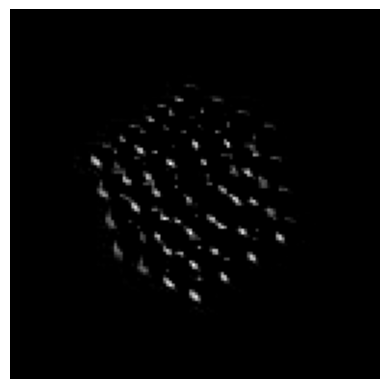

In [11]:
fig, ax = plt.subplots() #cela est l'image avant convolution
plt.imshow(img_0, cmap ="gray")
plt.axis("off")

F:\Temp\ipykernel_1528\382485938.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()   #image apres convolution


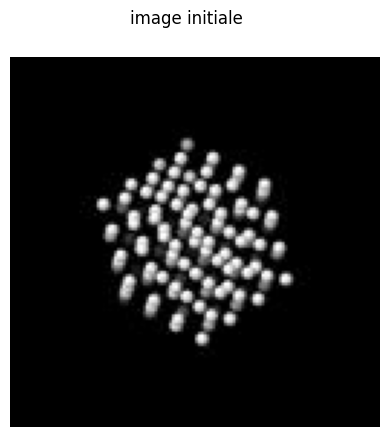

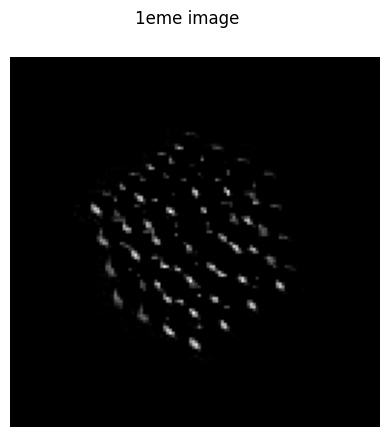

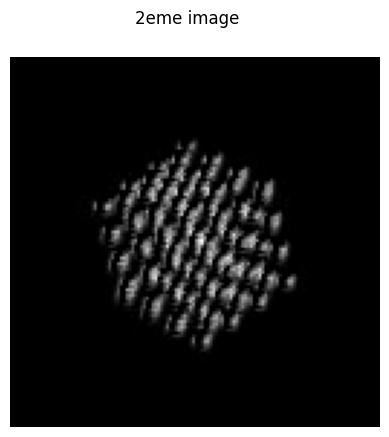

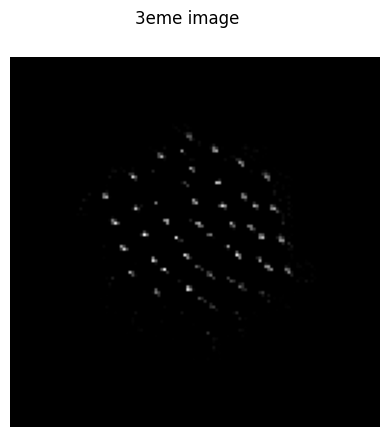

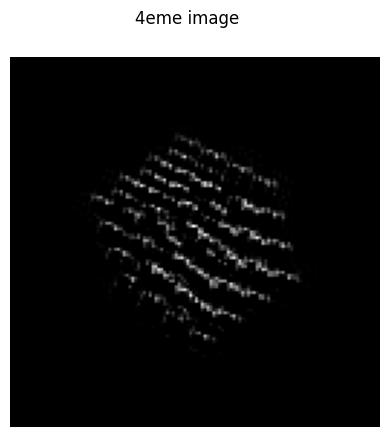

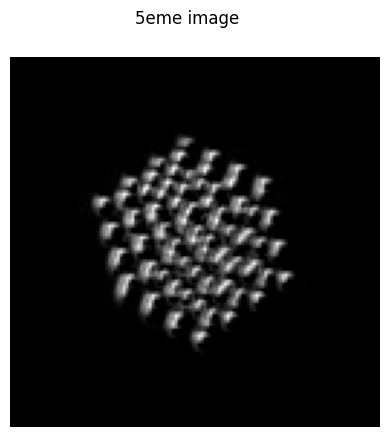

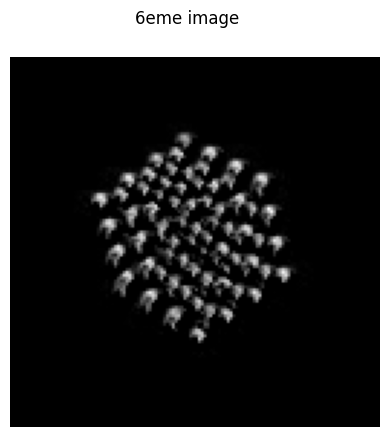

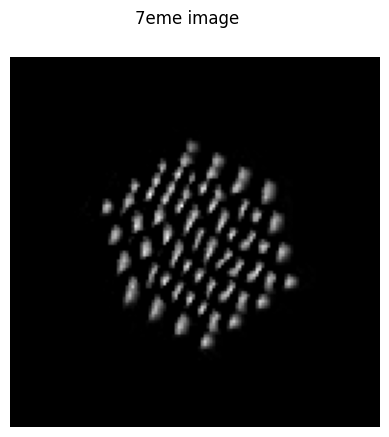

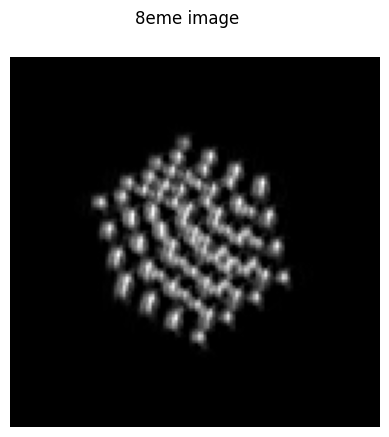

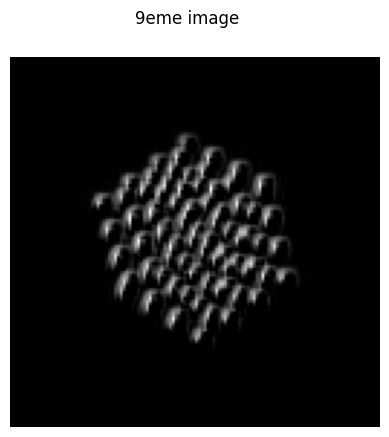

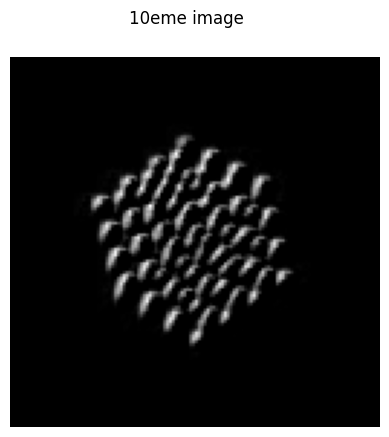

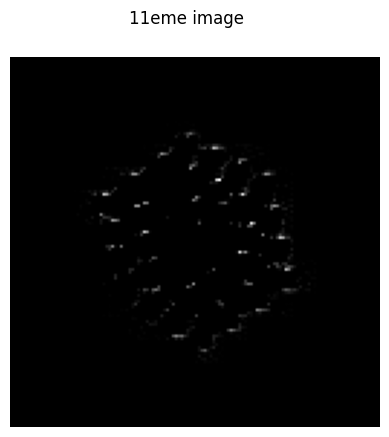

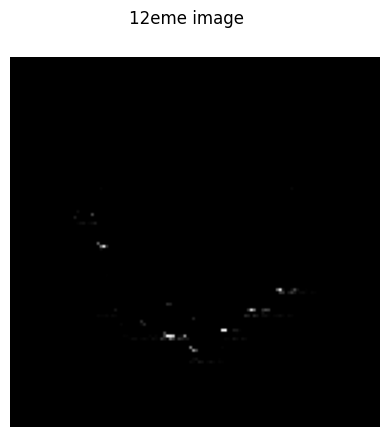

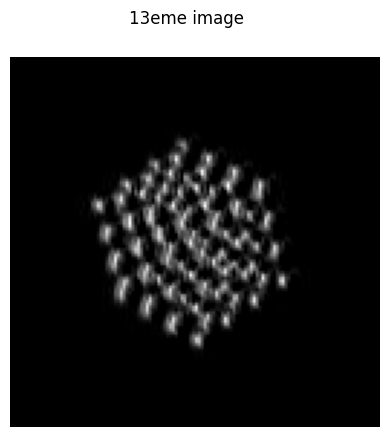

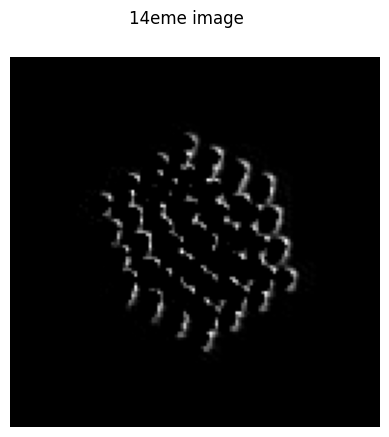

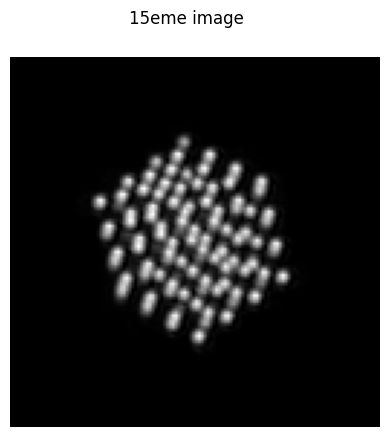

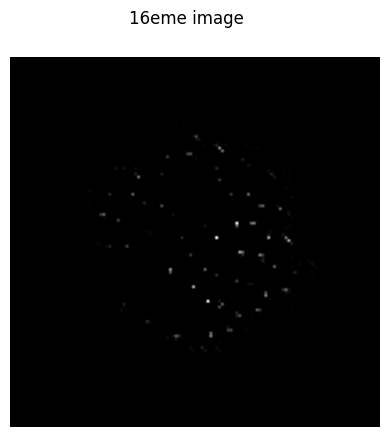

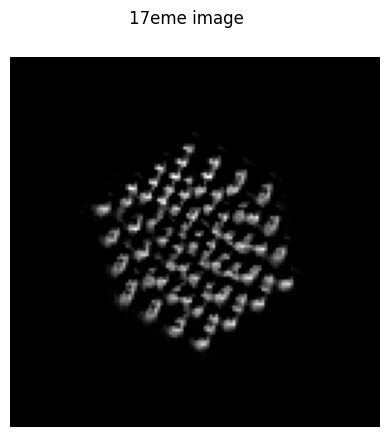

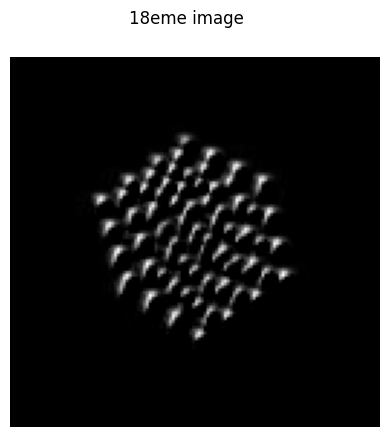

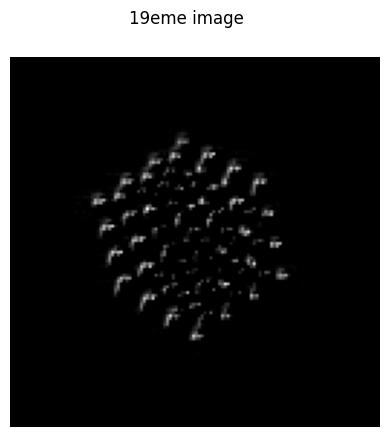

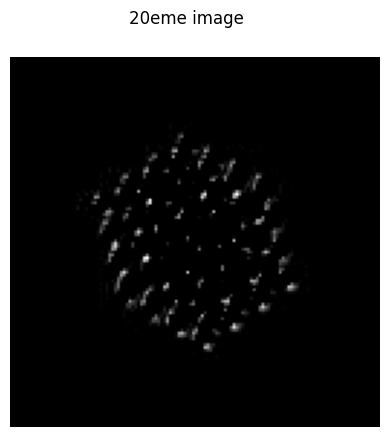

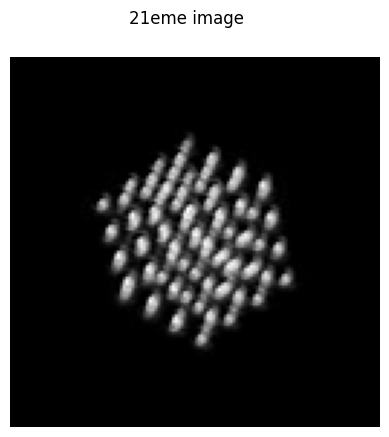

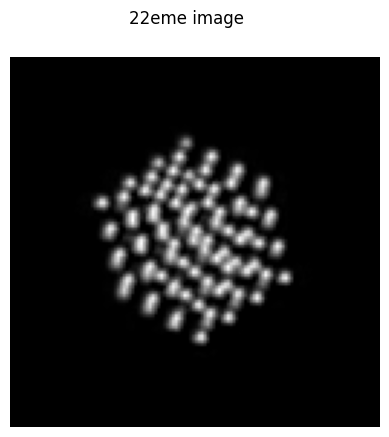

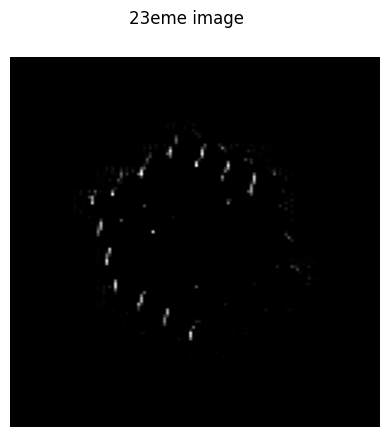

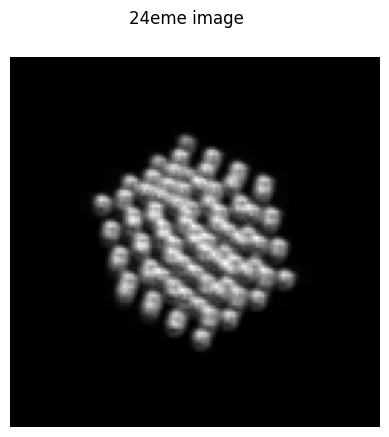

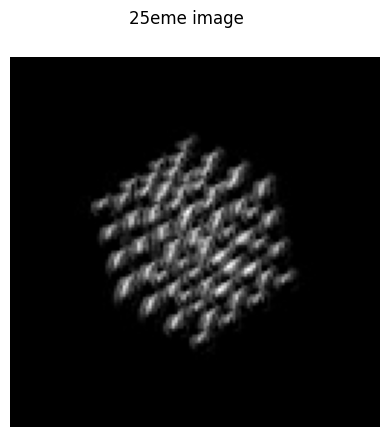

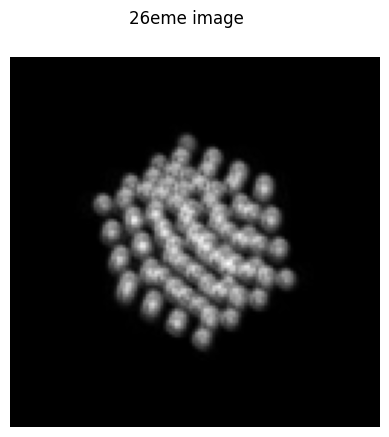

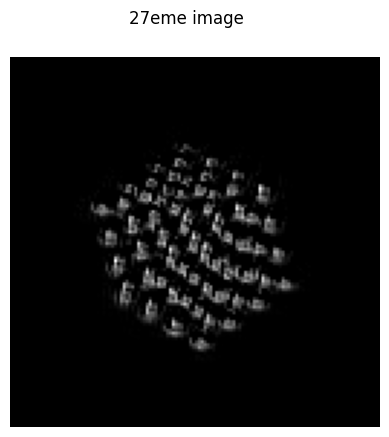

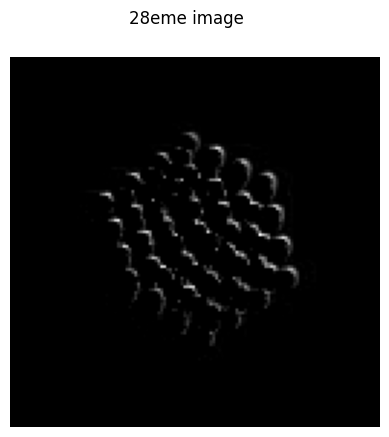

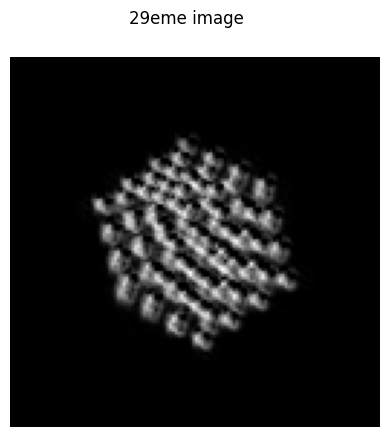

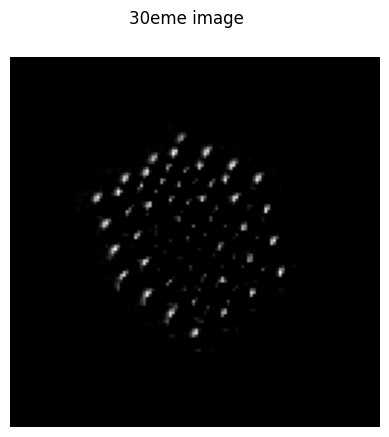

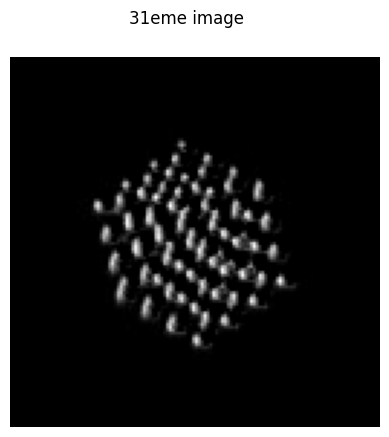

In [19]:
fig, ax = plt.subplots() #cela est l'image avant convolution
fig.suptitle("image initiale")
plt.imshow(img_init, cmap ="gray")
plt.axis("off")
deepth = un_img_convolue(index = 0 , matrix_4dim =img_convolued)[1]
#afficher tous les image dans profonder
for i in range(deepth-1):
    img = un_img_convolue(index = i, matrix_4dim =img_convolued)[0]
    fig, ax = plt.subplots()   #image apres convolution
    fig.suptitle(f'{i+1}eme image')
    plt.imshow(img,  cmap ="gray")
    plt.axis("off")


## connaitre les poid de model

In [14]:
poid = model.get_weights() #je ne comprend pas exactement c'est quoi ca
print(np.shape(poid[0]))

(1, 1, 1, 16)
